In [1]:
import numpy as np, geopandas as gpd, pandas as pd
from shapely.geometry import Point
# Pistes fictives (orientation en degrés, position)
RUNWAYS = [
    {"name":"R1","x":0,"y":0,"heading":90},
    {"name":"R2","x":0,"y":0,"heading":180},
]
GRID_STEP = 0.2  # km
LEVELS = [50, 55, 60, 65, 70]  # dB(A)

In [2]:
# grille (–10..10 km)
xs = np.arange(-10, 10+GRID_STEP, GRID_STEP)
ys = np.arange(-10, 10+GRID_STEP, GRID_STEP)
X, Y = np.meshgrid(xs, ys)

def lden_from_runway(x, y, rw):
    # cônes gaussiens alignés sur l’axe de la piste + décroissance radiale
    dx, dy = x - rw["x"], y - rw["y"]
    theta = np.deg2rad(rw["heading"])
    xr =  dx*np.cos(theta) + dy*np.sin(theta)     # axe piste
    yr = -dx*np.sin(theta) + dy*np.cos(theta)
    base = 75*np.exp(-(yr**2)/(2*1.5**2)) * np.exp(-np.clip(xr,0,None)/5)
    return base

L = np.zeros_like(X, dtype=float)
for rw in RUNWAYS:
    L = np.maximum(L, lden_from_runway(X, Y, rw))
L = np.clip(L, 30, None)  # plancher


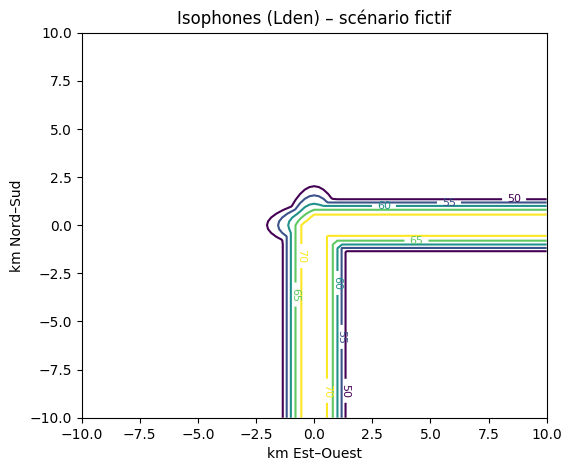

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,5))
cs = ax.contour(X, Y, L, levels=LEVELS)
ax.clabel(cs, inline=True, fontsize=8)
ax.set_title("Isophones (Lden) – scénario fictif")
ax.set_xlabel("km Est–Ouest"); ax.set_ylabel("km Nord–Sud")
plt.savefig("outputs/noise/noise_map_example.png", dpi=150, bbox_inches="tight")

# Export GeoJSON des points (optionnel, rapide)
gdf = gpd.GeoDataFrame({"Lden":L.ravel()},
                       geometry=[Point(x,y) for x,y in zip(X.ravel(),Y.ravel())],
                       crs="EPSG:3857")
gdf.to_file("outputs/noise/grid_points.geojson", driver="GeoJSON")
